A self-contained notebook for code associated with concepts you will face in [Statistical Thinking in Python (Part 2)](https://campus.datacamp.com/courses/statistical-thinking-in-python-part-2)

# Imports

In [1]:
import datetime
import glob
import itertools
import json
import os
import pickle
import random
import re
from string import punctuation

In [2]:
import statistics

import fuzzywuzzy
import geopandas as gpd
import humanize
import missingno as msno
import numpy as np
import pandas as pd
import recordlinkage
import scipy as sp
import statsmodels.formula.api as smf
from pandas_profiling import ProfileReport

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800
%matplotlib inline
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from matplotlib.ticker import PercentFormatter

px.set_mapbox_access_token(os.getenv("MAPBOX_TOKEN"))
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
plt.rcParams["figure.figsize"] = 15, 6
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Functions

In [4]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""

    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0, 1]

In [5]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

In [6]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""

    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

In [7]:
def draw_bs_reps(data, func, size=None):
    """Draw bootstrap replicates."""

    # Initialize array of replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

In [8]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0, len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, deg=1)

    return bs_slope_reps, bs_intercept_reps

In [9]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate([data1, data2])

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[: len(data1)]
    perm_sample_2 = permuted_data[len(data1) :]

    return perm_sample_1, perm_sample_2

In [10]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [11]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = data_1.mean() - data_2.mean()

    return diff

# Parameter Estimation by Optimization

## Optimal Parameters

If you assume that no-hitters are described as a Poisson process, then the time between no-hitters is Exponentially distributed.

In [12]:
nohitter_times = np.array(
    [
        843,
        1613,
        1101,
        215,
        684,
        814,
        278,
        324,
        161,
        219,
        545,
        715,
        966,
        624,
        29,
        450,
        107,
        20,
        91,
        1325,
        124,
        1468,
        104,
        1309,
        429,
        62,
        1878,
        1104,
        123,
        251,
        93,
        188,
        983,
        166,
        96,
        702,
        23,
        524,
        26,
        299,
        59,
        39,
        12,
        2,
        308,
        1114,
        813,
        887,
        645,
        2088,
        42,
        2090,
        11,
        886,
        1665,
        1084,
        2900,
        2432,
        750,
        4021,
        1070,
        1765,
        1322,
        26,
        548,
        1525,
        77,
        2181,
        2752,
        127,
        2147,
        211,
        41,
        1575,
        151,
        479,
        697,
        557,
        2267,
        542,
        392,
        73,
        603,
        233,
        255,
        528,
        397,
        1529,
        1023,
        1194,
        462,
        583,
        37,
        943,
        996,
        480,
        1497,
        717,
        224,
        219,
        1531,
        498,
        44,
        288,
        267,
        600,
        52,
        269,
        1086,
        386,
        176,
        2199,
        216,
        54,
        675,
        1243,
        463,
        650,
        171,
        327,
        110,
        774,
        509,
        8,
        197,
        136,
        12,
        1124,
        64,
        380,
        811,
        232,
        192,
        731,
        715,
        226,
        605,
        539,
        1491,
        323,
        240,
        179,
        702,
        156,
        82,
        1397,
        354,
        778,
        603,
        1001,
        385,
        986,
        203,
        149,
        576,
        445,
        180,
        1403,
        252,
        675,
        1351,
        2983,
        1568,
        45,
        899,
        3260,
        1025,
        31,
        100,
        2055,
        4043,
        79,
        238,
        3931,
        2351,
        595,
        110,
        215,
        0,
        563,
        206,
        660,
        242,
        577,
        179,
        157,
        192,
        192,
        1848,
        792,
        1693,
        55,
        388,
        225,
        1134,
        1172,
        1555,
        31,
        1582,
        1044,
        378,
        1687,
        2915,
        280,
        765,
        2819,
        511,
        1521,
        745,
        2491,
        580,
        2072,
        6450,
        578,
        745,
        1075,
        1103,
        1549,
        1520,
        138,
        1202,
        296,
        277,
        351,
        391,
        950,
        459,
        62,
        1056,
        1128,
        139,
        420,
        87,
        71,
        814,
        603,
        1349,
        162,
        1027,
        783,
        326,
        101,
        876,
        381,
        905,
        156,
        419,
        239,
        119,
        129,
        467,
    ]
)

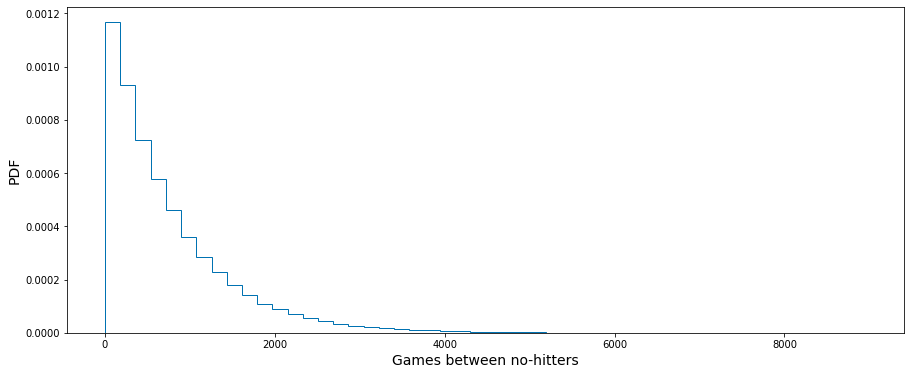

In [13]:
# Seed random number generator
np.random.seed(42)

# Compute mean no-hitter time: tau
tau = nohitter_times.mean()

# Draw out of an exponential distribution with parameter tau: inter_nohitter_time
inter_nohitter_time = np.random.exponential(tau, 100000)

# Plot the PDF and label axes
plt.hist(inter_nohitter_time, bins=50, density=True, histtype="step")
plt.xlabel("Games between no-hitters")
plt.ylabel("PDF")

# Show the plot
plt.show()

## ECDF Actual Data

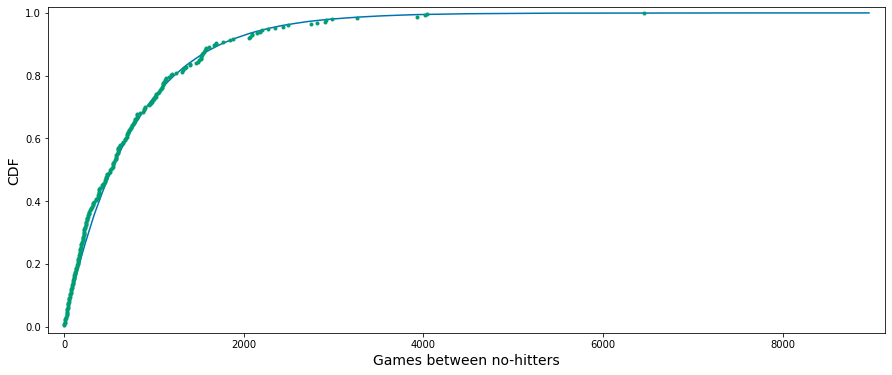

In [14]:
# Create an ECDF from real data: x, y
x, y = ecdf(nohitter_times)

# Create a CDF from theoretical samples: x_theor, y_theor
x_theor, y_theor = ecdf(inter_nohitter_time)

# Overlay the plots
plt.plot(x_theor, y_theor)
plt.plot(x, y, marker=".", linestyle="none")

# Margins and axis labels
plt.margins(0.02)
plt.xlabel("Games between no-hitters")
plt.ylabel("CDF")

# Show the plot
plt.show()

## Alternate CDFs

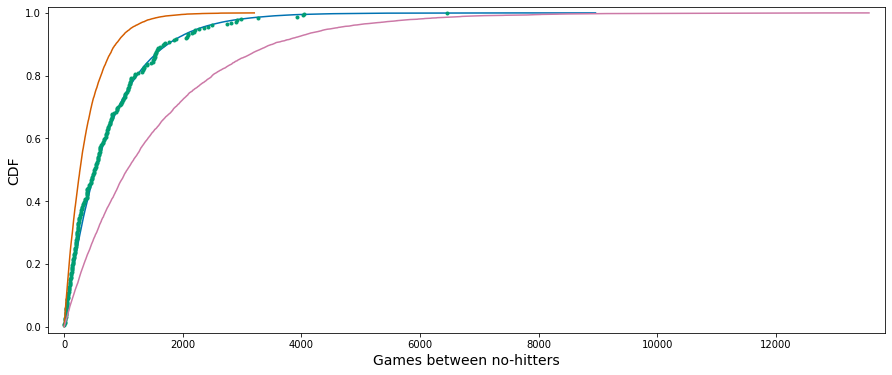

In [15]:
# Plot the theoretical CDFs
plt.plot(x_theor, y_theor)
plt.plot(x, y, marker=".", linestyle="none")
plt.margins(0.02)
plt.xlabel("Games between no-hitters")
plt.ylabel("CDF")

# Take samples with half tau: samples_half
samples_half = np.random.exponential(0.5 * tau, size=10000)

# Take samples with double tau: samples_double
samples_double = np.random.exponential(2.0 * tau, size=10000)

# Generate CDFs from these samples
x_half, y_half = ecdf(samples_half)
x_double, y_double = ecdf(samples_double)

# Plot these CDFs as lines
_ = plt.plot(x_half, y_half)
_ = plt.plot(x_double, y_double)

# Show the plot
plt.show()

## Optimal residual sum of squares (RSS)

In [16]:
illiteracy = np.array(
    [
        9.5,
        49.2,
        1.0,
        11.2,
        9.8,
        60.0,
        50.2,
        51.2,
        0.6,
        1.0,
        8.5,
        6.1,
        9.8,
        1.0,
        42.2,
        77.2,
        18.7,
        22.8,
        8.5,
        43.9,
        1.0,
        1.0,
        1.5,
        10.8,
        11.9,
        3.4,
        0.4,
        3.1,
        6.6,
        33.7,
        40.4,
        2.3,
        17.2,
        0.7,
        36.1,
        1.0,
        33.2,
        55.9,
        30.8,
        87.4,
        15.4,
        54.6,
        5.1,
        1.1,
        10.2,
        19.8,
        0.0,
        40.7,
        57.2,
        59.9,
        3.1,
        55.7,
        22.8,
        10.9,
        34.7,
        32.2,
        43.0,
        1.3,
        1.0,
        0.5,
        78.4,
        34.2,
        84.9,
        29.1,
        31.3,
        18.3,
        81.8,
        39.0,
        11.2,
        67.0,
        4.1,
        0.2,
        78.1,
        1.0,
        7.1,
        1.0,
        29.0,
        1.1,
        11.7,
        73.6,
        33.9,
        14.0,
        0.3,
        1.0,
        0.8,
        71.9,
        40.1,
        1.0,
        2.1,
        3.8,
        16.5,
        4.1,
        0.5,
        44.4,
        46.3,
        18.7,
        6.5,
        36.8,
        18.6,
        11.1,
        22.1,
        71.1,
        1.0,
        0.0,
        0.9,
        0.7,
        45.5,
        8.4,
        0.0,
        3.8,
        8.5,
        2.0,
        1.0,
        58.9,
        0.3,
        1.0,
        14.0,
        47.0,
        4.1,
        2.2,
        7.2,
        0.3,
        1.5,
        50.5,
        1.3,
        0.6,
        19.1,
        6.9,
        9.2,
        2.2,
        0.2,
        12.3,
        4.9,
        4.6,
        0.3,
        16.5,
        65.7,
        63.5,
        16.8,
        0.2,
        1.8,
        9.6,
        15.2,
        14.4,
        3.3,
        10.6,
        61.3,
        10.9,
        32.2,
        9.3,
        11.6,
        20.7,
        6.5,
        6.7,
        3.5,
        1.0,
        1.6,
        20.5,
        1.5,
        16.7,
        2.0,
        0.9,
    ]
)

fertility = np.array(
    [
        1.769,
        2.682,
        2.077,
        2.132,
        1.827,
        3.872,
        2.288,
        5.173,
        1.393,
        1.262,
        2.156,
        3.026,
        2.033,
        1.324,
        2.816,
        5.211,
        2.1,
        1.781,
        1.822,
        5.908,
        1.881,
        1.852,
        1.39,
        2.281,
        2.505,
        1.224,
        1.361,
        1.468,
        2.404,
        5.52,
        4.058,
        2.223,
        4.859,
        1.267,
        2.342,
        1.579,
        6.254,
        2.334,
        3.961,
        6.505,
        2.53,
        2.823,
        2.498,
        2.248,
        2.508,
        3.04,
        1.854,
        4.22,
        5.1,
        4.967,
        1.325,
        4.514,
        3.173,
        2.308,
        4.62,
        4.541,
        5.637,
        1.926,
        1.747,
        2.294,
        5.841,
        5.455,
        7.069,
        2.859,
        4.018,
        2.513,
        5.405,
        5.737,
        3.363,
        4.89,
        1.385,
        1.505,
        6.081,
        1.784,
        1.378,
        1.45,
        1.841,
        1.37,
        2.612,
        5.329,
        5.33,
        3.371,
        1.281,
        1.871,
        2.153,
        5.378,
        4.45,
        1.46,
        1.436,
        1.612,
        3.19,
        2.752,
        3.35,
        4.01,
        4.166,
        2.642,
        2.977,
        3.415,
        2.295,
        3.019,
        2.683,
        5.165,
        1.849,
        1.836,
        2.518,
        2.43,
        4.528,
        1.263,
        1.885,
        1.943,
        1.899,
        1.442,
        1.953,
        4.697,
        1.582,
        2.025,
        1.841,
        5.011,
        1.212,
        1.502,
        2.516,
        1.367,
        2.089,
        4.388,
        1.854,
        1.748,
        2.978,
        2.152,
        2.362,
        1.988,
        1.426,
        3.29,
        3.264,
        1.436,
        1.393,
        2.822,
        4.969,
        5.659,
        3.24,
        1.693,
        1.647,
        2.36,
        1.792,
        3.45,
        1.516,
        2.233,
        2.563,
        5.283,
        3.885,
        0.966,
        2.373,
        2.663,
        1.251,
        2.052,
        3.371,
        2.093,
        2.0,
        3.883,
        3.852,
        3.718,
        1.732,
        3.928,
    ]
)

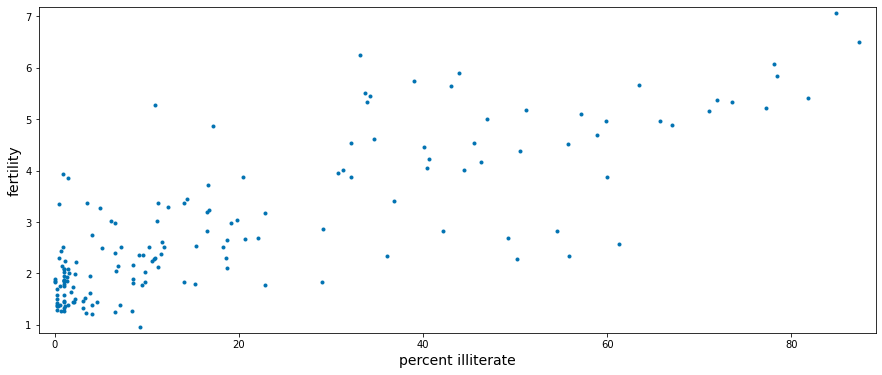

0.8041324026815341


In [17]:
# Plot the illiteracy rate versus fertility
_ = plt.plot(illiteracy, fertility, marker=".", linestyle="none")

# Set the margins and label axes
plt.margins(0.02)
_ = plt.xlabel("percent illiterate")
_ = plt.ylabel("fertility")

# Show the plot
plt.show()

# Show the Pearson correlation coefficient
print(pearson_r(illiteracy, fertility))

slope = 0.04979854809063418 children per woman / percent illiterate
intercept = 1.888050610636557 children per woman


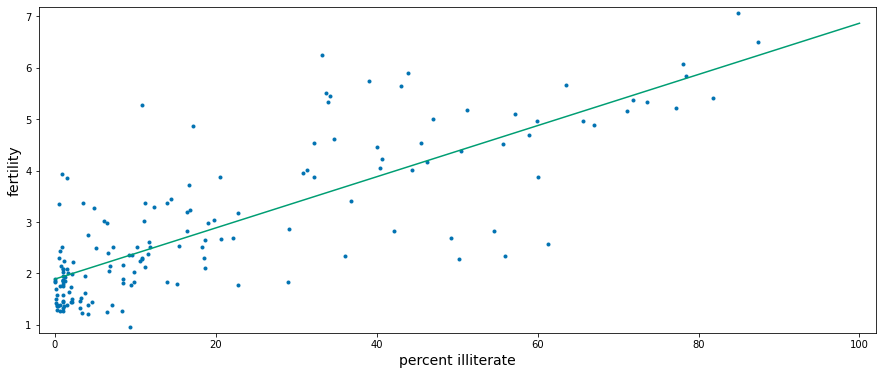

In [18]:
# Plot the illiteracy rate versus fertility
_ = plt.plot(illiteracy, fertility, marker=".", linestyle="none")
plt.margins(0.02)
_ = plt.xlabel("percent illiterate")
_ = plt.ylabel("fertility")

# Perform a linear regression using np.polyfit(): a, b
a, b = np.polyfit(illiteracy, fertility, deg=1)

# Print the results to the screen
print("slope =", a, "children per woman / percent illiterate")
print("intercept =", b, "children per woman")

# Make theoretical line to plot
x = np.array([0, 100])
y = a * x + b

# Add regression line to your plot
_ = plt.plot(x, y)

# Draw the plot
plt.show()

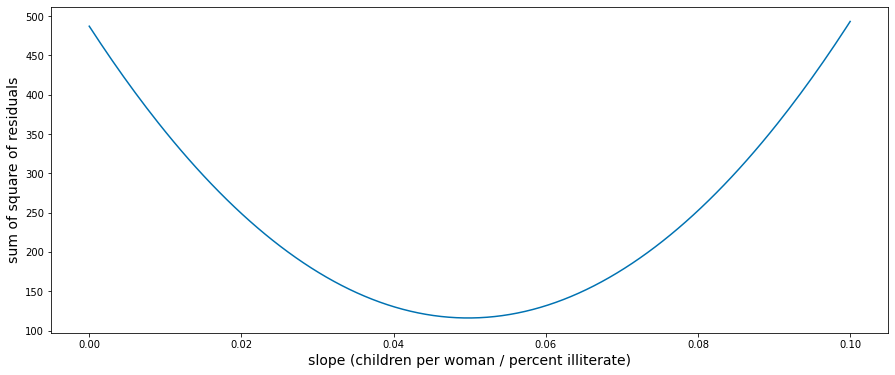

In [19]:
# Specify slopes to consider: a_vals
a_vals = np.linspace(0, 0.1, 200)

# Initialize sum of square of residuals: rss
rss = np.empty_like(a_vals)

# Compute sum of square of residuals for each value of a_vals
for i, a in enumerate(a_vals):
    rss[i] = np.sum((fertility - a * illiteracy - b) ** 2)

# Plot the RSS
plt.plot(a_vals, rss, "-")
plt.xlabel("slope (children per woman / percent illiterate)")
plt.ylabel("sum of square of residuals")

plt.show()

# Bootstrapping

## Bootstrap Sampling

In [20]:
rainfall = np.array(
    [
        875.5,
        648.2,
        788.1,
        940.3,
        491.1,
        743.5,
        730.1,
        686.5,
        878.8,
        865.6,
        654.9,
        831.5,
        798.1,
        681.8,
        743.8,
        689.1,
        752.1,
        837.2,
        710.6,
        749.2,
        967.1,
        701.2,
        619.0,
        747.6,
        803.4,
        645.6,
        804.1,
        787.4,
        646.8,
        997.1,
        774.0,
        734.5,
        835.0,
        840.7,
        659.6,
        828.3,
        909.7,
        856.9,
        578.3,
        904.2,
        883.9,
        740.1,
        773.9,
        741.4,
        866.8,
        871.1,
        712.5,
        919.2,
        927.9,
        809.4,
        633.8,
        626.8,
        871.3,
        774.3,
        898.8,
        789.6,
        936.3,
        765.4,
        882.1,
        681.1,
        661.3,
        847.9,
        683.9,
        985.7,
        771.1,
        736.6,
        713.2,
        774.5,
        937.7,
        694.5,
        598.2,
        983.8,
        700.2,
        901.3,
        733.5,
        964.4,
        609.3,
        1035.2,
        718.0,
        688.6,
        736.8,
        643.3,
        1038.5,
        969.0,
        802.7,
        876.6,
        944.7,
        786.6,
        770.4,
        808.6,
        761.3,
        774.2,
        559.3,
        674.2,
        883.6,
        823.9,
        960.4,
        877.8,
        940.6,
        831.8,
        906.2,
        866.5,
        674.1,
        998.1,
        789.3,
        915.0,
        737.1,
        763.0,
        666.7,
        824.5,
        913.8,
        905.1,
        667.8,
        747.4,
        784.7,
        925.4,
        880.2,
        1086.9,
        764.4,
        1050.1,
        595.2,
        855.2,
        726.9,
        785.2,
        948.8,
        970.6,
        896.0,
        618.4,
        572.4,
        1146.4,
        728.2,
        864.2,
        793.0,
    ]
)

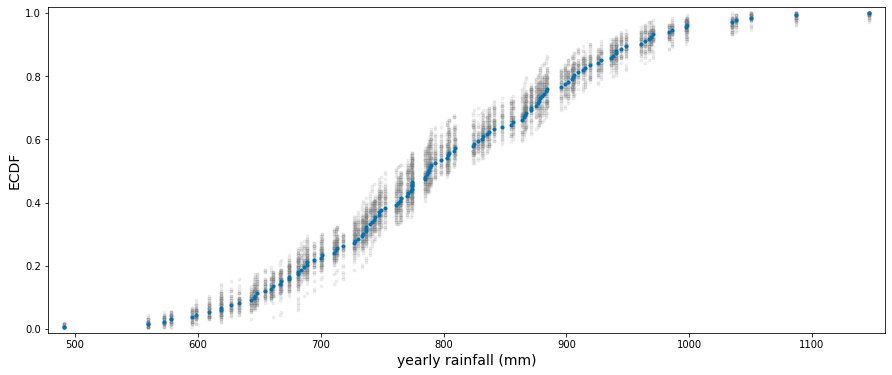

In [21]:
for _ in range(50):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.random.choice(rainfall, size=len(rainfall))

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = plt.plot(x, y, marker=".", linestyle="none", color="gray", alpha=0.1)

# Compute and plot ECDF from original data
x, y = ecdf(rainfall)
_ = plt.plot(x, y, linestyle="none", marker=".")

# Make margins and label axes
plt.margins(0.02)
_ = plt.xlabel("yearly rainfall (mm)")
_ = plt.ylabel("ECDF")

# Show the plot
plt.show()

## Bootstrap Confidence Intervals

95% confidence interval = [779.96900376 820.62793233] games


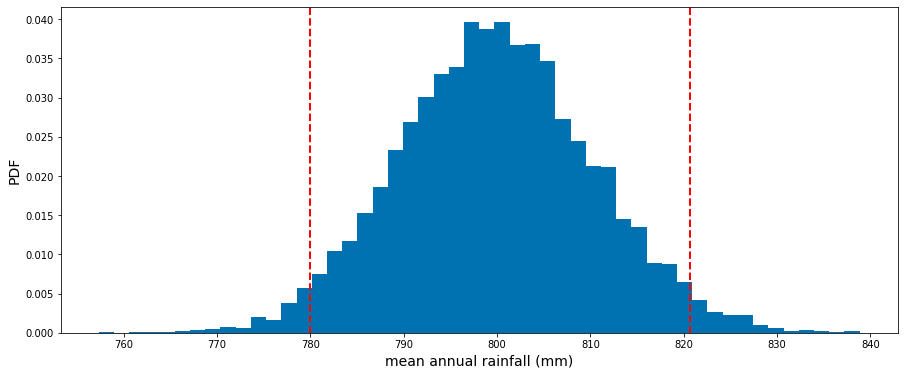

In [22]:
# Draw bootstrap replicates of the mean no-hitter time (equal to tau): bs_replicates
bs_replicates = draw_bs_reps(rainfall, np.mean, 10000)

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

# Print the confidence interval
print("95% confidence interval =", conf_int, "games")

# Plot the histogram of the replicates
plt.hist(bs_replicates, bins=50, density=True)
for c in conf_int:
    plt.axvline(c, color="r", linewidth=2, linestyle="dashed")
plt.xlabel("mean annual rainfall (mm)")
plt.ylabel("PDF")

# Show the plot
plt.show()

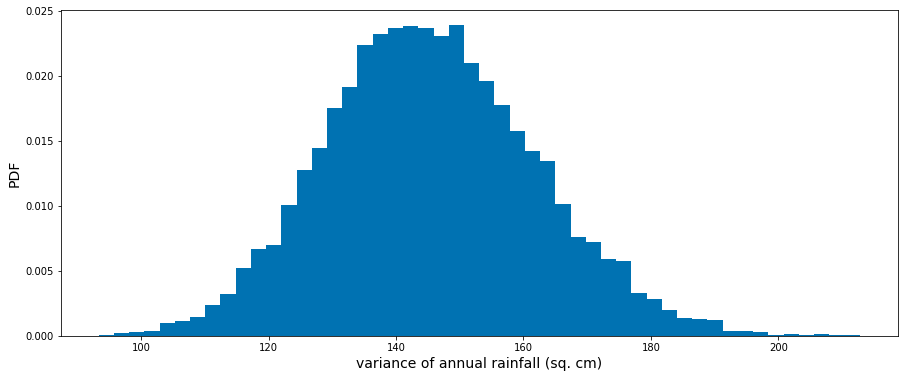

In [23]:
# Generate 10,000 bootstrap replicates of the variance: bs_replicates
bs_replicates = draw_bs_reps(rainfall, np.var, 10000)

# Put the variance in units of square centimeters
bs_replicates /= 100

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, density=True)
_ = plt.xlabel("variance of annual rainfall (sq. cm)")
_ = plt.ylabel("PDF")

# Show the plot
plt.show()

95% confidence interval = [663.65229084 869.79741036] games


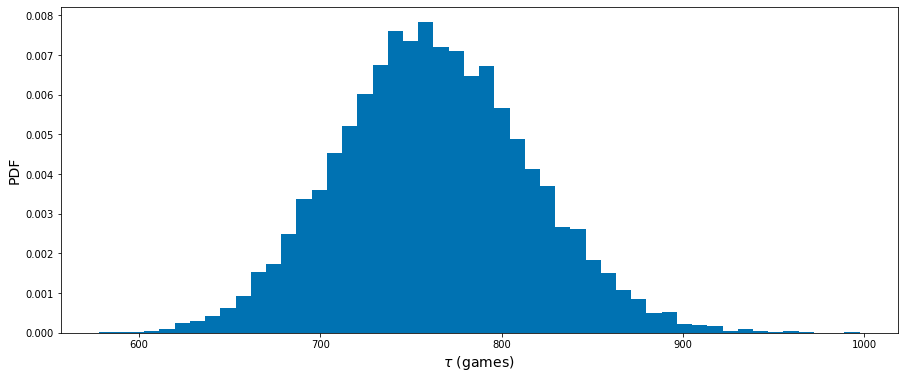

In [24]:
# Draw bootstrap replicates of the mean no-hitter time (equal to tau): bs_replicates
bs_replicates = draw_bs_reps(nohitter_times, np.mean, 10000)

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

# Print the confidence interval
print("95% confidence interval =", conf_int, "games")

# Plot the histogram of the replicates
_ = plt.hist(bs_replicates, bins=50, density=True)
_ = plt.xlabel(r"$\tau$ (games)")
_ = plt.ylabel("PDF")

# Show the plot
plt.show()

## Pairs Bootstrap

[0.04389859 0.05528877]


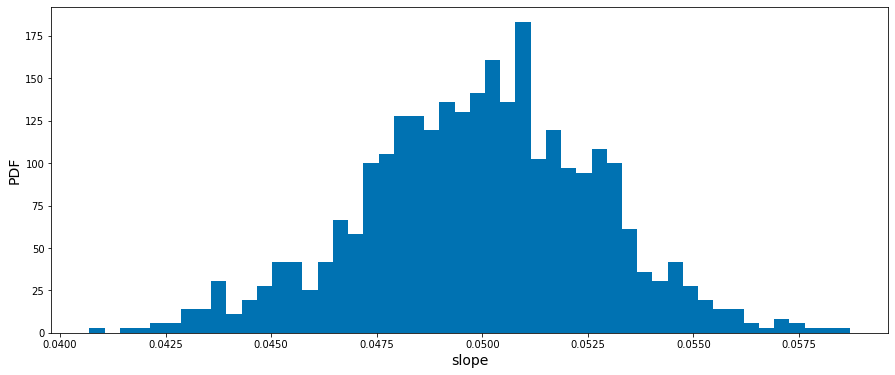

In [25]:
# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(
    illiteracy, fertility, size=1000
)

# Compute and print 95% CI for slope
print(np.percentile(bs_slope_reps, [2.5, 97.5]))

# Plot the histogram
_ = plt.hist(bs_slope_reps, bins=50, density=True)
_ = plt.xlabel("slope")
_ = plt.ylabel("PDF")
plt.show()

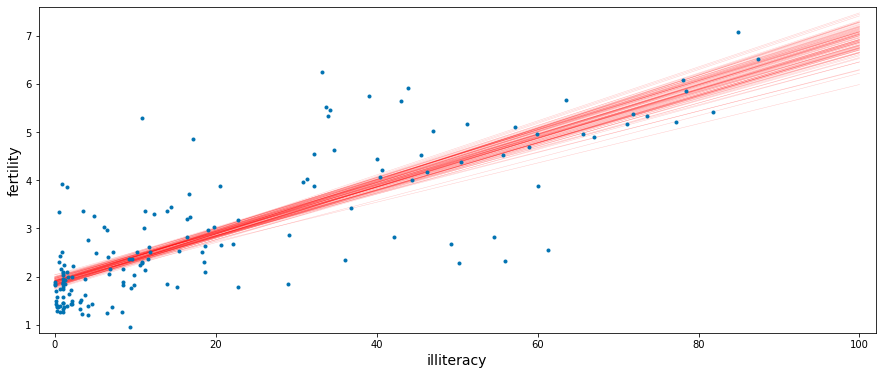

In [26]:
# Generate array of x-values for bootstrap lines: x
x = np.array([0, 100])

# Plot the bootstrap lines
for i in range(100):
    _ = plt.plot(
        x,
        bs_slope_reps[i] * x + bs_intercept_reps[i],
        linewidth=0.5,
        alpha=0.2,
        color="red",
    )

# Plot the data
_ = plt.plot(illiteracy, fertility, marker=".", linestyle="none")

# Label axes, set the margins, and show the plot
_ = plt.xlabel("illiteracy")
_ = plt.ylabel("fertility")
plt.margins(0.02)
plt.show()

# Hypothesis Testing

1. State the null hypothesis
2. Define test stats
3. Generate simulated data assuming null hypothesis is true
4. Compute test stat for each sim data set
5. Compute p-value: fraction of sim data for which test stat is at least as extreme as for the real data

## Permutation Samples

In [27]:
rain_june = np.array(
    [
        66.2,
        39.7,
        76.4,
        26.5,
        11.2,
        61.8,
        6.1,
        48.4,
        89.2,
        104.0,
        34.0,
        60.6,
        57.1,
        79.1,
        90.9,
        32.3,
        63.8,
        78.2,
        27.5,
        43.4,
        30.1,
        17.3,
        77.5,
        44.9,
        92.2,
        39.6,
        79.4,
        66.1,
        53.5,
        98.5,
        20.8,
        55.5,
        39.6,
        56.0,
        65.1,
        14.8,
        13.2,
        88.1,
        8.4,
        32.1,
        19.6,
        40.4,
        2.2,
        77.5,
        105.4,
        77.2,
        38.0,
        27.1,
        111.8,
        17.2,
        26.7,
        23.3,
        77.2,
        87.2,
        27.7,
        50.6,
        60.3,
        15.1,
        6.0,
        29.4,
        39.3,
        56.3,
        80.4,
        85.3,
        68.4,
        72.5,
        13.3,
        28.4,
        14.7,
        37.4,
        49.5,
        57.2,
        85.9,
        82.1,
        31.8,
        126.6,
        30.7,
        41.4,
        33.9,
        13.5,
        99.1,
        70.2,
        91.8,
        61.3,
        13.7,
        54.9,
        62.5,
        24.2,
        69.4,
        83.1,
        44.0,
        48.5,
        11.9,
        16.6,
        66.4,
        90.0,
        34.9,
        132.8,
        33.4,
        225.0,
        7.6,
        40.9,
        76.5,
        48.0,
        140.0,
        55.9,
        54.1,
        46.4,
        68.6,
        52.2,
        108.3,
        14.6,
        11.3,
        29.8,
        130.9,
        152.4,
        61.0,
        46.6,
        43.9,
        30.9,
        111.1,
        68.5,
        42.2,
        9.8,
        285.6,
        56.7,
        168.2,
        41.2,
        47.8,
        166.6,
        37.8,
        45.4,
        43.2,
    ]
)

rain_november = np.array(
    [
        83.6,
        30.9,
        62.2,
        37.0,
        41.0,
        160.2,
        18.2,
        122.4,
        71.3,
        44.2,
        49.1,
        37.6,
        114.5,
        28.8,
        82.5,
        71.9,
        50.7,
        67.7,
        112.0,
        63.6,
        42.8,
        57.2,
        99.1,
        86.4,
        84.4,
        38.1,
        17.7,
        102.2,
        101.3,
        58.0,
        82.0,
        101.4,
        81.4,
        100.1,
        54.6,
        39.6,
        57.5,
        29.2,
        48.8,
        37.3,
        115.4,
        55.6,
        62.0,
        95.0,
        84.2,
        118.1,
        153.2,
        83.4,
        104.7,
        59.0,
        46.4,
        50.0,
        147.6,
        76.8,
        59.9,
        101.8,
        136.6,
        173.0,
        92.5,
        37.0,
        59.8,
        142.1,
        9.9,
        158.2,
        72.6,
        28.0,
        112.9,
        119.3,
        199.2,
        50.7,
        44.0,
        170.7,
        67.2,
        21.4,
        61.3,
        15.6,
        106.0,
        116.2,
        42.3,
        38.5,
        132.5,
        40.8,
        147.5,
        93.9,
        71.4,
        87.3,
        163.7,
        141.4,
        62.6,
        84.9,
        28.8,
        121.1,
        28.6,
        32.4,
        112.0,
        50.0,
        96.9,
        81.8,
        70.4,
        117.5,
        41.2,
        124.9,
        78.2,
        93.0,
        53.5,
        50.5,
        42.6,
        47.9,
        73.1,
        129.1,
        56.9,
        103.3,
        60.5,
        134.3,
        93.1,
        49.5,
        48.2,
        167.9,
        27.0,
        111.1,
        55.4,
        36.2,
        57.4,
        66.8,
        58.3,
        60.0,
        161.6,
        112.7,
        37.4,
        110.6,
        56.6,
        95.8,
        126.8,
    ]
)

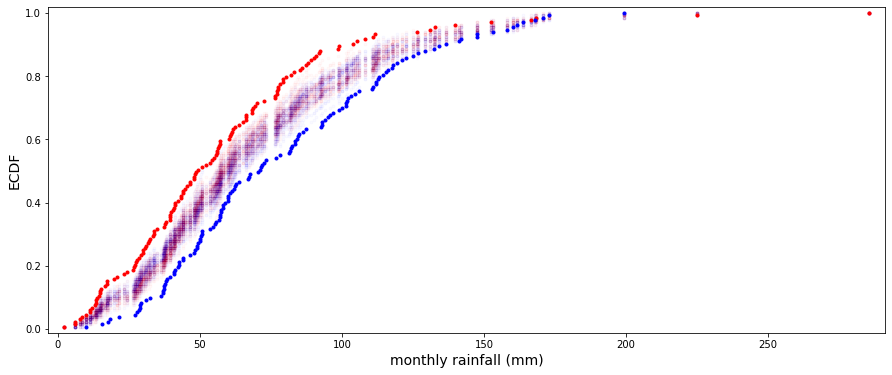

In [28]:
for i in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(rain_june, rain_november)

    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    _ = plt.plot(x_1, y_1, marker=".", linestyle="none", color="red", alpha=0.02)
    _ = plt.plot(x_2, y_2, marker=".", linestyle="none", color="blue", alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(rain_june)
x_2, y_2 = ecdf(rain_november)
_ = plt.plot(x_1, y_1, marker=".", linestyle="none", color="red")
_ = plt.plot(x_2, y_2, marker=".", linestyle="none", color="blue")

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel("monthly rainfall (mm)")
_ = plt.ylabel("ECDF")
plt.show()

## Test Statistics

In [29]:
force_a = np.array(
    [
        1.612,
        0.605,
        0.327,
        0.946,
        0.541,
        1.539,
        0.529,
        0.628,
        1.453,
        0.297,
        0.703,
        0.269,
        0.751,
        0.245,
        1.182,
        0.515,
        0.435,
        0.383,
        0.457,
        0.73,
    ]
)

force_b = np.array(
    [
        0.172,
        0.142,
        0.037,
        0.453,
        0.355,
        0.022,
        0.502,
        0.273,
        0.72,
        0.582,
        0.198,
        0.198,
        0.597,
        0.516,
        0.815,
        0.402,
        0.605,
        0.711,
        0.614,
        0.468,
    ]
)

In [30]:
# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(force_a, force_b, diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print("p-value =", p)

p-value = 0.0058


## Bootstrap Hypothesis Test

In [31]:
# A one-sample bootstrap hypothesis test

# set random seed/
np.random.seed(42)

# Make an array of translated impact forces: translated_force_b
translated_force_b = force_b - np.mean(force_b) + 0.55

# Take bootstrap replicates of Frog B's translated impact forces: bs_replicates
bs_replicates = draw_bs_reps(translated_force_b, np.mean, 10000)

# Compute fraction of replicates that are less than the observed Frog B force: p
p = np.sum(bs_replicates <= np.mean(force_b)) / 10000

# Print the p-value
print("p = ", p)

p =  0.0046


In [32]:
# A two-sample bootstrap hypothesis test for difference of means

# data
forces_concat = np.array(
    [
        1.612,
        0.605,
        0.327,
        0.946,
        0.541,
        1.539,
        0.529,
        0.628,
        1.453,
        0.297,
        0.703,
        0.269,
        0.751,
        0.245,
        1.182,
        0.515,
        0.435,
        0.383,
        0.457,
        0.73,
        0.172,
        0.142,
        0.037,
        0.453,
        0.355,
        0.022,
        0.502,
        0.273,
        0.72,
        0.582,
        0.198,
        0.198,
        0.597,
        0.516,
        0.815,
        0.402,
        0.605,
        0.711,
        0.614,
        0.468,
    ]
)

# Compute mean of all forces: mean_force
mean_force = forces_concat.mean()

# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, 10000)
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, 10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)
print("p-value =", p)

p-value = 0.0042


# Hypothesis Testing Examples

## A/B Testing

A/B testing is often used by organizations to see if a change in strategy gives different, hopefully better, results. Generally, the null hypothesis in an A/B test is that your test statistic is impervious to the change. A low p-value implies that the change in strategy lead to a change in performance. Once again, though, be warned that statistical significance does not mean practical significance. A difference in click-though rate may be statistically significant, but if it is only a couple people more per day, your marketing team may not consider the change worth the cost. A/B testing is just a special case of the hypothesis testing framework we have already been working with, a fun and informative one.

Imagine your company has a proposed redesign of the splash page of its website. They are interested in how many more users click through to the website for the redesign versus the original design. You devise a test.

Take a set of 1000 visitors to the site and direct 500 of them to the original splash page and 500 of them to the redesigned one. You determine whether or not each of them clicks through to the rest of the website. On the original page, which we'll call page A.

45 visitors clicked through, and on the redesigned page, page B, 67 visitors clicked through. This makes you happy because that is almost a 50% increase in the click-through rate. But maybe there really is no difference between the effect of two designs on click-through rate and the difference you saw is due the random chance. You want to check: what is the probability that you would observe at least the observed difference in number of clicks through if that were the case?

This is asking exactly the question you can address with a hypothesis test. A permutation test is a good choice here because you can simulate the result as if the redesign had no effect on the click-through rate.

### Civil Rights Act Vote

The Civil Rights Act of 1964 was one of the most important pieces of legislation ever passed in the USA. Excluding "present" and "abstain" votes, 153 House Democrats and 136 Republicans voted yea. However, 91 Democrats and 35 Republicans voted nay. Did party affiliation make a difference in the vote?

In [33]:
# Construct arrays of data: dems, reps
dem_votes = np.array([True] * 153 + [False] * 91)
gop_votes = np.array([True] * 136 + [False] * 35)
actual_yeas = np.sum(dem_votes) / np.sum(gop_votes)


def frac_yea_dems(dems, reps):
    """Compute fraction of Democrat yea votes."""
    frac = np.sum(dems) / len(dems)
    return frac


# Acquire permutation samples: perm_replicates
perm_replicates = draw_perm_reps(dem_votes, gop_votes, frac_yea_dems, 10000)

# Compute and print p-value: p
p = np.sum(perm_replicates <= 153 / 244) / len(perm_replicates)
print("p-value =", p)

p-value = 0.0001


### No-Hitters

We return to the no-hitter data set. In 1920, Major League Baseball implemented important rule changes that ended the so-called dead ball era. Importantly, the pitcher was no longer allowed to spit on or scuff the ball, an activity that greatly favors pitchers. In this problem you will perform an A/B test to determine if these rule changes resulted in a slower rate of no-hitters (i.e., longer average time between no-hitters) using the difference in mean inter-no-hitter time as your test statistic. The inter-no-hitter times for the respective eras are stored in the arrays nht_dead and nht_live, where "nht" is meant to stand for "no-hitter time."

In [34]:
nht_dead = np.array(
    [
        -1,
        894,
        10,
        130,
        1,
        934,
        29,
        6,
        485,
        254,
        372,
        81,
        191,
        355,
        180,
        286,
        47,
        269,
        361,
        173,
        246,
        492,
        462,
        1319,
        58,
        297,
        31,
        2970,
        640,
        237,
        434,
        570,
        77,
        271,
        563,
        3365,
        89,
        0,
        379,
        221,
        479,
        367,
        628,
        843,
        1613,
        1101,
        215,
        684,
        814,
        278,
        324,
        161,
        219,
        545,
        715,
        966,
        624,
        29,
        450,
        107,
        20,
        91,
        1325,
        124,
        1468,
        104,
        1309,
        429,
        62,
        1878,
        1104,
        123,
        251,
        93,
        188,
        983,
        166,
        96,
        702,
        23,
        524,
        26,
        299,
        59,
        39,
        12,
        2,
        308,
        1114,
        813,
        887,
    ]
)
nht_live = np.array(
    [
        645,
        2088,
        42,
        2090,
        11,
        886,
        1665,
        1084,
        2900,
        2432,
        750,
        4021,
        1070,
        1765,
        1322,
        26,
        548,
        1525,
        77,
        2181,
        2752,
        127,
        2147,
        211,
        41,
        1575,
        151,
        479,
        697,
        557,
        2267,
        542,
        392,
        73,
        603,
        233,
        255,
        528,
        397,
        1529,
        1023,
        1194,
        462,
        583,
        37,
        943,
        996,
        480,
        1497,
        717,
        224,
        219,
        1531,
        498,
        44,
        288,
        267,
        600,
        52,
        269,
        1086,
        386,
        176,
        2199,
        216,
        54,
        675,
        1243,
        463,
        650,
        171,
        327,
        110,
        774,
        509,
        8,
        197,
        136,
        12,
        1124,
        64,
        380,
        811,
        232,
        192,
        731,
        715,
        226,
        605,
        539,
        1491,
        323,
        240,
        179,
        702,
        156,
        82,
        1397,
        354,
        778,
        603,
        1001,
        385,
        986,
        203,
        149,
        576,
        445,
        180,
        1403,
        252,
        675,
        1351,
        2983,
        1568,
        45,
        899,
        3260,
        1025,
        31,
        100,
        2055,
        4043,
        79,
        238,
        3931,
        2351,
        595,
        110,
        215,
        0,
        563,
        206,
        660,
        242,
        577,
        179,
        157,
        192,
        192,
        1848,
        792,
        1693,
        55,
        388,
        225,
        1134,
        1172,
        1555,
        31,
        1582,
        1044,
        378,
        1687,
        2915,
        280,
        765,
        2819,
        511,
        1521,
        745,
        2491,
        580,
        2072,
        6450,
        578,
        745,
        1075,
        1103,
        1549,
        1520,
        138,
        1202,
        296,
        277,
        351,
        391,
        950,
        459,
        62,
        1056,
        1128,
        139,
        420,
        87,
        71,
        814,
        603,
        1349,
        162,
        1027,
        783,
        326,
        101,
        876,
        381,
        905,
        156,
        419,
        239,
        119,
        129,
        467,
    ]
)

In [35]:
# Compute the observed difference in mean inter-no-hitter times: nht_diff_obs
nht_diff_obs = diff_of_means(nht_dead, nht_live)

# Acquire 10,000 permutation replicates of difference in mean no-hitter time: perm_replicates
perm_replicates = draw_perm_reps(nht_dead, nht_live, diff_of_means, size=10000)


# Compute and print the p-value: p
p = np.sum(perm_replicates <= nht_diff_obs) / len(perm_replicates)
print("p-val =", p)

p-val = 0.0


Your p-value is 0.0001, which means that only one out of your 10,000 replicates had a result as extreme as the actual difference between the dead ball and live ball eras. This suggests strong statistical significance. Watch out, though, you could very well have gotten zero replicates that were as extreme as the observed value. This just means that the p-value is quite small, almost certainly smaller than 0.001.

## Test of Correlation

### Female Illiteracy and Fertility

Hypothesis test on Pearson correlation:

The observed correlation between female illiteracy and fertility in the data set of 162 countries may just be by chance; the fertility of a given country may actually be totally independent of its illiteracy. You will test this null hypothesis in the next exercise.

To do the test, you need to simulate the data assuming the null hypothesis is true. Of the following choices, which is the best way to do it?

Do a permutation test: Permute the illiteracy values but leave the fertility values fixed to generate a new set of (illiteracy, fertility) data. Yes, this exactly simulates the null hypothesis and does so more efficiently than the last option. It is exact because it uses all data and eliminates any correlation because which illiteracy value pairs to which fertility value is shuffled.

In [36]:
# Compute observed correlation: r_obs
r_obs = pearson_r(illiteracy, fertility)

# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(100000)

# Draw replicates
for i in range(10000):
    # Permute illiteracy measurments: illiteracy_permuted
    illiteracy_permuted = np.random.permutation(illiteracy)

    # Compute Pearson correlation
    perm_replicates[i] = pearson_r(illiteracy_permuted, fertility)

# Compute p-value: p
p = np.sum(perm_replicates >= r_obs) / len(perm_replicates)
print("p-val =", p)

p-val = 0.0


You got a p-value of zero. In hacker statistics, this means that your p-value is very low, since you never got a single replicate in the 10,000 you took that had a Pearson correlation greater than the observed one. You could try increasing the number of replicates you take to continue to move the upper bound on your p-value lower and lower.

### Neonicotinoid Insecticides

In a recent study, [Straub, et al. (Proc. Roy. Soc. B, 2016)](http://dx.doi.org/10.1098/rspb.2016.0506) investigated the effects of neonicotinoids on the sperm of pollinating bees. In this and the next exercise, you will study how the pesticide treatment affected the count of live sperm per half milliliter of semen.

First, we will do EDA, as usual. Plot ECDFs of the alive sperm count for untreated bees (stored in the Numpy array control) and bees treated with pesticide (stored in the Numpy array treated).

In [37]:
control = np.array(
    [
        4.159234,
        4.408002,
        0.172812,
        3.498278,
        3.104912,
        5.164174,
        6.615262,
        4.633066,
        0.170408,
        2.65,
        0.0875,
        1.997148,
        6.92668,
        4.574932,
        3.896466,
        5.209814,
        3.70625,
        0.0,
        4.62545,
        3.01444,
        0.732652,
        0.4,
        6.518382,
        5.225,
        6.218742,
        6.840358,
        1.211308,
        0.368252,
        3.59937,
        4.212158,
        6.052364,
        2.115532,
        6.60413,
        5.26074,
        6.05695,
        6.481172,
        3.171522,
        3.057228,
        0.218808,
        5.215112,
        4.465168,
        2.28909,
        3.732572,
        2.17087,
        1.834326,
        6.074862,
        5.841978,
        8.524892,
        4.698492,
        2.965624,
        2.324206,
        3.409412,
        4.830726,
        0.1,
        0.0,
        4.101432,
        3.478162,
        1.009688,
        4.999296,
        4.32196,
        0.299592,
        3.606032,
        7.54026,
        4.284024,
        0.057494,
        6.036668,
        2.924084,
        4.150144,
        1.256926,
        4.666502,
        4.806594,
        2.52478,
        2.027654,
        2.52283,
        4.735598,
        2.033236,
        0.0,
        6.177294,
        2.601834,
        3.544408,
        3.6045,
        5.520346,
        4.80698,
        3.002478,
        3.559816,
        7.075844,
        10.0,
        0.139772,
        6.17171,
        3.201232,
        8.459546,
        0.17857,
        7.088276,
        5.496662,
        5.415086,
        1.932282,
        3.02838,
        7.47996,
        1.86259,
        7.838498,
        2.242718,
        3.292958,
        6.363644,
        4.386898,
        8.47533,
        4.156304,
        1.463956,
        4.533628,
        5.573922,
        1.29454,
        7.547504,
        3.92466,
        5.820258,
        4.118522,
        4.125,
        2.286698,
        0.591882,
        1.273124,
        0.0,
        0.0,
        0.0,
        12.22502,
        7.601604,
        5.56798,
        1.679914,
        8.77096,
        5.823942,
        0.258374,
        0.0,
        5.899236,
        5.486354,
        2.053148,
        3.25541,
        2.72564,
        3.364066,
        2.43427,
        5.282548,
        3.963666,
        0.24851,
        0.347916,
        4.046862,
        5.461436,
        4.066104,
        0.0,
        0.065,
    ]
)
treated = np.array(
    [
        1.342686,
        1.058476,
        3.793784,
        0.40428,
        4.528388,
        2.142966,
        3.937742,
        0.1375,
        6.919164,
        0.0,
        3.597812,
        5.196538,
        2.78955,
        2.3229,
        1.090636,
        5.323916,
        1.021618,
        0.931836,
        2.78,
        0.412202,
        1.180934,
        2.8674,
        0.0,
        0.064354,
        3.008348,
        0.876634,
        0.0,
        4.971712,
        7.280658,
        4.79732,
        2.084956,
        3.251514,
        1.9405,
        1.566192,
        0.58894,
        5.219658,
        0.977976,
        3.124584,
        1.297564,
        1.433328,
        4.24337,
        0.880964,
        2.376566,
        3.763658,
        1.918426,
        3.74,
        3.841726,
        4.69964,
        4.386876,
        0.0,
        1.127432,
        1.845452,
        0.690314,
        4.185602,
        2.284732,
        7.237594,
        2.185148,
        2.799124,
        3.43218,
        0.63354,
        1.142496,
        0.586,
        2.372858,
        1.80032,
        3.329306,
        4.028804,
        3.474156,
        7.508752,
        2.032824,
        1.336556,
        1.906496,
        1.396046,
        2.488104,
        4.759114,
        1.07853,
        3.19927,
        3.814252,
        4.275962,
        2.817056,
        0.552198,
        3.27194,
        5.11525,
        2.064628,
        0.0,
        3.34101,
        6.177322,
        0.0,
        3.66415,
        2.352582,
        1.531696,
    ]
)

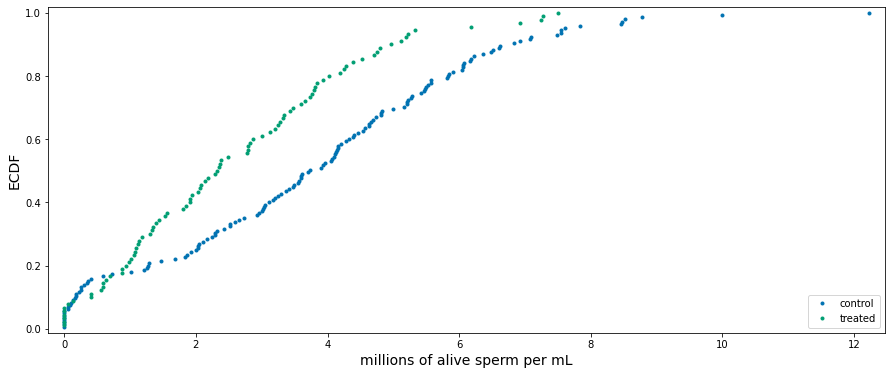

In [38]:
# Compute x,y values for ECDFs
x_control, y_control = ecdf(control)
x_treated, y_treated = ecdf(treated)

# Plot the ECDFs
plt.plot(x_control, y_control, marker=".", linestyle="none")
plt.plot(x_treated, y_treated, marker=".", linestyle="none")

# Set the margins
plt.margins(0.02)

# Add a legend
plt.legend(("control", "treated"), loc="lower right")

# Label axes and show plot
plt.xlabel("millions of alive sperm per mL")
plt.ylabel("ECDF")
plt.show()

Bootstrap hypothesis test on bee sperm counts

Null hypothesis: On average, male bees treated with neonicotinoid insecticide have the same number of active sperm per milliliter of semen than do untreated male bees. You will use the difference of means as your test statistic.

In [39]:
# Compute the difference in mean sperm count: diff_means
diff_means = np.mean(control) - np.mean(treated)

# Compute mean of pooled data: mean_count
mean_count = np.mean(np.concatenate((control, treated)))

# Generate shifted data sets
control_shifted = control - np.mean(control) + mean_count
treated_shifted = treated - np.mean(treated) + mean_count

# Generate bootstrap replicates
bs_reps_control = draw_bs_reps(control_shifted, np.mean, size=10000)
bs_reps_treated = draw_bs_reps(treated_shifted, np.mean, size=10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_reps_control - bs_reps_treated

# Compute and print p-value: p
p = np.sum(bs_replicates >= np.mean(control) - np.mean(treated)) / len(bs_replicates)
print("p-value =", p)

p-value = 0.0002


The p-value is small, most likely less than 0.0001, since you never saw a bootstrap replicated with a difference of means at least as extreme as what was observed. In fact, when I did the calculation with 10 million replicates, I got a p-value of 2e-05.